In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### Installing Albumentations library for Image Augmentations

In [ ]:

!pip install albumentations

## Importing Libraries

In [239]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import random
import math
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision import datasets, models, transforms

import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout

from torch.utils.data import Dataset, DataLoader

import torch.optim as optim
from torch.optim import lr_scheduler, Adam, SGD

import torch.nn.functional as F
from torch.autograd import Variable

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import time
import os
import copy

import random

import cv2

import albumentations as A
from IPython.display import Image

import cv2
from PIL import Image

###### Function to Visualize the images

In [ ]:
def visualize(image):
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.imshow(image)

### Defining Transformers

In [ ]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'training_set': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test_set': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

## Importing Data
#### Datasets

In [ ]:
data_dir = '/kaggle/input/dogs-cats-images/dog vs cat/dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['training_set', 'test_set']}


#### Visualising a Image

In [ ]:
print(image_datasets['training_set'][0][0].shape)
example = image_datasets['training_set'][7000]
image = example[0]
label = example[1]
t = image.numpy().transpose((1, 2, 0))
visualize(t)
print(label)

## DATALOADERS

In [ ]:
dataloaders = {
    'train' : torch.utils.data.DataLoader(image_datasets['training_set'], batch_size=16,
                                             shuffle=True, num_workers=0),
    'val'  : torch.utils.data.DataLoader(image_datasets['test_set'], batch_size=16,
                                             shuffle=True, num_workers=0),
}
dataset_sizes = {'train' : len(image_datasets['training_set']),
                 'val' : len(image_datasets['test_set'])
                }
class_names = image_datasets['training_set'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

#### Visualisation

In [ ]:
def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Defining the Paths for Checkpoints

In [ ]:
import shutil
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    f_path = checkpoint_path
    torch.save(state, f_path)
    if is_best:
        best_fpath = best_model_path
        shutil.copyfile(f_path, best_fpath)

In [ ]:
#,"./checkpoint/current_checkpoint.pt", "./best_model/best_model.pt"

#### Creating directories for Model Checkpoints

In [ ]:
!mkdir ./best_model
!mkdir ./checkpoint

In [ ]:
ls

# MODEL

### Training Function

In [ ]:
def train_model(n_epochs, valid_loss_min_input, loaders, model, optimizer, criterion, use_cuda, 
                checkpoint_path, best_model_path,scheduler):
    since = time.time()

    #best_model_wts = copy.deepcopy(model.state_dict())
    valid_best_acc = 0.0
    best_loss = 0.0
    # initialize tracker for minimum validation loss
    valid_loss_min = valid_loss_min_input 

    for epoch in range(n_epochs):
        print('Epoch {}/{}'.format(epoch, n_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                if use_cuda:
                    inputs, labels = inputs.cuda(), labels.cuda()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val':
                valid_acc = epoch_acc
                valid_loss = epoch_loss
                print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
                ###############################################################################################################
                checkpoint = {
                    'epoch': epoch + 1,
                    'valid_loss_min': valid_loss,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'scheduler' : scheduler.state_dict()
                }
                save_ckp(checkpoint, False, checkpoint_path, best_model_path)
                ## TODO: save the model if validation loss has decreased
                if valid_loss <= valid_loss_min:
                    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
                    save_ckp(checkpoint, True, checkpoint_path, best_model_path)
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    #best_model_wts = copy.deepcopy(model.state_dict())
                ################################################################################################################

        print()
        

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(valid_best_acc))
    print('Min val Loss: {:4f}'.format(valid_loss_min))

    # load best model weights
    #model.load_state_dict(best_model_wts)
    return model

### Importing ResNet15
We are usung resnet18. We are adding a Linear layer with output = num_classes for our dataset.
Initialising Optimizer, Criterion, Scheduler.

In [ ]:
use_cuda = torch.cuda.is_available()
#### ConvNet as fixed feature extractor ####
# Here, we need to freeze all the network except the final layer.
# We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### Training the Model
We are training the model for 3 Epochs only

In [ ]:
trained_model = train_model(10, np.Inf, dataloaders, model_conv, optimizer_conv, criterion, use_cuda
                            ,"./checkpoint/current_checkpoint.pt", "./best_model/best_model.pt",scheduler=exp_lr_scheduler)

# Loading the model

In [ ]:
def load_ckp(checkpoint_fpath, model, optimizer,scheduler):
    checkpoint = torch.load(checkpoint_fpath)
    #loading model with the saved parameters
    model.load_state_dict(checkpoint['state_dict'])
    #setting optimizer to the saved stage
    optimizer.load_state_dict(checkpoint['optimizer'])
    #setting scheduler to the saved stage
    scheduler.load_state_dict(checkpoint['scheduler'])
    
    valid_loss_min = checkpoint['valid_loss_min']
    
    return model, optimizer,scheduler, valid_loss_min,checkpoint['epoch'], 

In [ ]:
%pwd
%ls

In [ ]:
model = trained_model
# move model to GPU if CUDA is available|
if use_cuda:
    model = model.cuda()

print(model)

In [ ]:
optimizer = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
ckp_path = "./checkpoint/current_checkpoint.pt"

model , optimizer, scheduler, valid_loss_min, epoch = load_ckp(ckp_path, model, optimizer,scheduler)
#This Model's State_dict is set to the state of the model when it was finished with trainning
print(f'No of Epoch on which the Model was trained: {epoch}')

## The Best Model

In [ ]:
ckp_path = "./best_model/best_model.pt"
best_model , optimizer, scheduler, valid_loss_min, epoch = load_ckp(ckp_path, model, optimizer,scheduler)
#This Model's State_dict is set to the state of the model when it was finished with trainning
print(f'No of Epoch on which the Model was trained: {epoch}')
print(f'Valid Loss: {valid_loss_min}')

We can train above model further and achieve better results. For that, we have to give "valid_loss_min" in the training function.

In [ ]:
further_trained_model = train_model(3, valid_loss_min , dataloaders, best_model, optimizer, criterion, use_cuda
                            ,"./checkpoint/current_checkpoint.pt", "./best_model/best_model.pt",scheduler)

In [ ]:
final_model , optimizer, scheduler, valid_loss_min, epoch = load_ckp(ckp_path, further_trained_model, optimizer,scheduler)

In [125]:
final_model = final_model.eval()

# Predicting for a Image

In [237]:
def predict(image_path):
    image = cv2.imread(image_path) #using the direct image and converting it to array
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    visualize(image)
    transform  = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    k = Image.open('./image.jpeg')
    transformed_test_image = transform(k)
    
    output = final_model(transformed_test_image.unsqueeze(0).cuda())
    pred = nn.Softmax(-1)(output)

    index = torch.argmax(pred, dim=-1).item()
    print(f"The image is of a {class_names[index][:-1].upper()}")
    

### Downloading a Dog Image

In [126]:
import requests  
file_url = "https://i.insider.com/5df126b679d7570ad2044f3e?width=1100&format=jpeg&auto=webp"
    
r = requests.get(file_url, stream = True)  
  
with open("./image.jpeg", "wb") as file:  
    for block in r.iter_content(chunk_size = 1024): 
         if block:  
             file.write(block)

The image is of a DOG


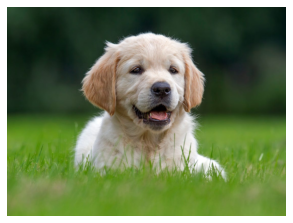

In [240]:
predict('./image.jpeg')

### Downloading a Cat Image

In [241]:
import requests  
file_url = "https://english.mathrubhumi.com/polopoly_fs/1.1844474.1588749145!/image/image.jpg_gen/derivatives/landscape_1080_600/image.jpg"
    
r = requests.get(file_url, stream = True)  
  
with open("./image.jpeg", "wb") as file:  
    for block in r.iter_content(chunk_size = 1024): 
         if block:  
             file.write(block)

The image is of a CAT


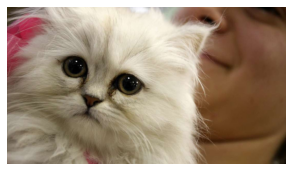

In [242]:
predict('./image.jpeg')